In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import operator

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Useful Functions

def plot_login_cycles(dataframe, by_column):
    login_by_column = dataframe[[by_column,'count']].groupby(by_column).mean()
    login_by_column.columns = ['average']
    login_by_column['average'].plot()
    _ = plt.xlabel("Time Interval ({})".format(by_column))
    _ = plt.ylabel("Average logins")
    _ = plt.title("Login cycle ({})".format(by_column))
    plt.show()
    
def plot_retained_ratio(dataframe, by_column):
    login_by_column = dataframe[[by_column,'retained']].groupby(by_column).mean()
    login_by_column.columns = ['average']
    login_by_column['average'].plot(kind='bar')
    _ = plt.xlabel(by_column)
    _ = plt.ylabel("Retained Ratio")
    _ = plt.title("Retained Ratio per {}".format(by_column))
    plt.show()
    
def preprocess(trainset, categories, features, target):
    dataset = trainset.copy()
    
    for column in categories:
        dataset[column] = dataset[column].astype('category')
    
    dataset = dataset[features]
    trainset = trainset[[target]].join(dataset)
    return trainset

def train(X_train, y_train, X_val, y_val, verbose):
    params = {
        "objective" : "binary",
        "metric" : "auc",
        "boosting": "gbdt",
        "verbosity" : -1,
        "seed": 41,
        "early_stopping_round": 100
    }
    
    lgtrain = lgb.Dataset(X_train, label=y_train)
    lgval = lgb.Dataset(X_val, label=y_val)
    evals_result = {}
    model = lgb.train(params, lgtrain, 3000, valid_sets=[lgval], verbose_eval=verbose, evals_result=evals_result)
    score = evals_result['valid_0']['auc'][-1]
    return  model

def run_lgbm(X_train, X_val, X_test, features, target, verbose=False):
    X_train, y_train = X_train[features], X_train[target]
    X_val, y_val = X_val[features], X_val[target]
    X_test, y_test = X_test[features], X_test[target]
    
    model = train(X_train, y_train, X_val, y_val, verbose)
    
    score1 = roc_auc_score(y_train, model.predict(X_train))
    score2 = roc_auc_score(y_val, model.predict(X_val))
    score3 = roc_auc_score(y_test, model.predict(X_test))
    
    return model, score1, score2, score3

def feature_importance_by_score(X_train, X_val, X_test, features, target, compare_score):
    score_map = {}
    for index, name in enumerate(features):
        new_features = features[:index] + features[index+1:]
        model, train_score, val_score, test_score = run_lgbm(X_train, X_val, X_test, features=new_features, target=target)
        score = val_score - compare_score
        score_map[name] = score
    score_map = sorted(score_map.items(), key=operator.itemgetter(1))
    return score_map

## Part 1 ‑ Exploratory data analysis
<p>The attached logins.json file contains (simulated) timestamps of user logins in a particular geographic location. Aggregate these login counts based on 15­minute time intervals, and visualize and describe the resulting time series of login counts in ways that best characterize the underlying patterns of the demand. Please report/illustrate important features of the demand, such as daily cycles. If there are data quality issues, please report them.</p>

In [3]:
logins_df = pd.read_json("logins.json")
logins_df = logins_df.sort_values('login_time')
logins_df.head()

,login_time
6,1970-01-01 20:12:16
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
3,1970-01-01 20:16:36
2,1970-01-01 20:16:37


In [4]:
logins_df.tail()

,login_time
93136,1970-04-13 18:48:52
93137,1970-04-13 18:50:19
93139,1970-04-13 18:54:02
93141,1970-04-13 18:54:23
93140,1970-04-13 18:57:38


In [5]:
logins_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 93142 entries, 6 to 93140
Data columns (total 1 columns):
login_time    93142 non-null datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 1.4 MB


In [6]:
logins_df.describe()

,login_time
count,93142
unique,92265
top,1970-04-04 01:17:40
freq,3
first,1970-01-01 20:12:16
last,1970-04-13 18:57:38


The data contains login details for 4 months and 13 days. Since, the date starts from 1st January, 1970 (start of Unix epoch time), date information is not correct and hence should be ignored.

In [7]:
logins_df['epoch_minutes'] = (logins_df['login_time'].astype('int') / (1000*1000*1000*60)).astype('int')
logins_df['time_interval'] = (logins_df['epoch_minutes'] / 15).astype('int')
logins_df.head()

,login_time,epoch_minutes,time_interval
6,1970-01-01 20:12:16,1212,80
0,1970-01-01 20:13:18,1213,80
1,1970-01-01 20:16:10,1216,81
3,1970-01-01 20:16:36,1216,81
2,1970-01-01 20:16:37,1216,81


In [8]:
logins_count_df = logins_df[['login_time','time_interval']].groupby('time_interval').count()
logins_count_df = logins_count_df.reset_index()
logins_count_df.columns = ['time_interval', 'count']
logins_count_df.head()

,time_interval,count
0,80,2
1,81,6
2,82,9
3,83,7
4,84,1


In [9]:
logins_count_df['hour'] = (logins_count_df['time_interval'] / 4).astype('int') % 24
logins_count_df['date'] = (logins_count_df['time_interval'] / (4*24)).astype('int')
logins_count_df['day'] = logins_count_df['date'] % 7
logins_count_df['quarter'] = logins_count_df['time_interval'] % 4
logins_count_df.head()

,time_interval,count,hour,date,day,quarter
0,80,2,20,0,0,0
1,81,6,20,0,0,1
2,82,9,20,0,0,2
3,83,7,20,0,0,3
4,84,1,21,0,0,0


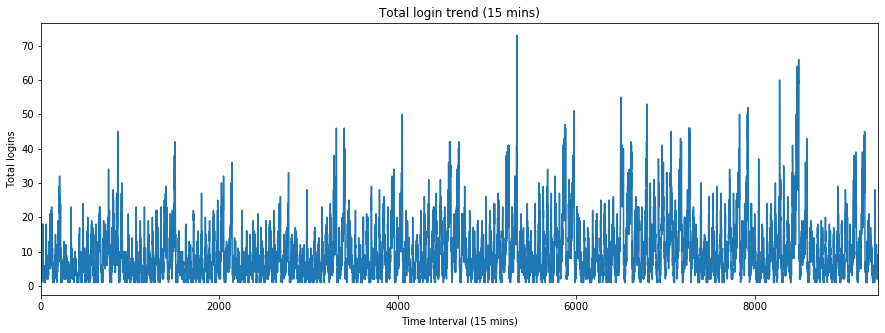

In [10]:
logins_count_df['count'].plot(figsize=(15,5))
_ = plt.xlabel("Time Interval (15 mins)")
_ = plt.ylabel("Total logins")
_ = plt.title("Total login trend (15 mins)")
plt.show()

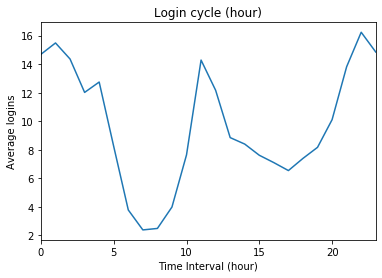

In [11]:
plot_login_cycles(logins_count_df, 'hour')

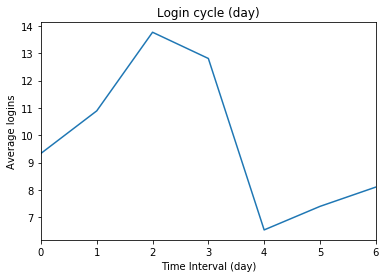

In [12]:
plot_login_cycles(logins_count_df, 'day')

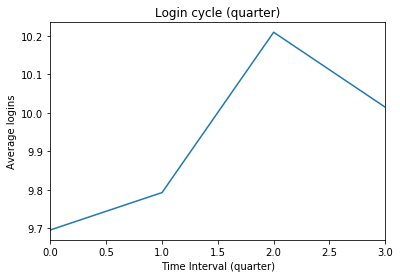

In [13]:
plot_login_cycles(logins_count_df, 'quarter')

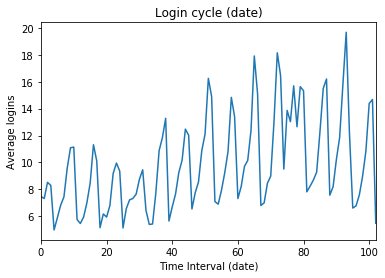

In [14]:
plot_login_cycles(logins_count_df, 'date')

Below are some conclusion of above plots
- Logins are very low in the morning hours, moderate in the evening and high at noon and night
- Day 4 has very low logins and day 2 has very high logins. Since, we do not know the date, we could not tell the day 4 belongs to which day of week.
- Logins are low in the 1st quarter and very high in the 3rd quarter
- Logins increased with the dates

## Part 3 ‑ Predictive modeling

<p>Ultimate is interested in predicting rider retention. To help explore this question, we have provided a sample dataset of a cohort of users who signed up for an Ultimate account in January 2014. The data was pulled several months later; we consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days.</p>
<p>We would like you to use this data set to help understand what factors are the best predictors for retention, and offer suggestions to operationalize those insights to help Ultimate.</p>
<ol>
<li>Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?</li>
<li>Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.</li>
<li>Briefly discuss how Ultimate might leverage the insights gained from the model to improve its long-term rider retention (again, a few sentences will suffice).</li>
</ol>


In [15]:
with open('ultimate_data_challenge.json') as datafile:
    data = json.load(datafile)
users_df = pd.DataFrame(data)
users_df['signup_date'] = pd.to_datetime(users_df['signup_date'])
users_df['last_trip_date'] = pd.to_datetime(users_df['last_trip_date'])
users_df['phone'] = users_df['phone'].fillna('Others')
users_df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [16]:
users_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
city                      50000 non-null object
trips_in_first_30_days    50000 non-null int64
signup_date               50000 non-null datetime64[ns]
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
last_trip_date            50000 non-null datetime64[ns]
phone                     50000 non-null object
surge_pct                 50000 non-null float64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
dtypes: bool(1), datetime64[ns](2), float64(6), int64(1), object(2)
memory usage: 4.2+ MB


In [17]:
users_df.last_trip_date.describe()

count                   50000
unique                    182
top       2014-06-29 00:00:00
freq                     2036
first     2014-01-01 00:00:00
last      2014-07-01 00:00:00
Name: last_trip_date, dtype: object

Determine whether or not a user will be active in their 6th month on the system, that means user's the last trip date is between 1st June to 1st July.
Since, the last date in the dataset is 1st July, we can simply put that month is 6 or 7

In [18]:
users_df['retained'] = (users_df['last_trip_date'].dt.month >= 6).astype('int')
users_df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,retained
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,1
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,1
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,0


In [19]:
users_df['retained'].value_counts()

0    31196
1    18804
Name: retained, dtype: int64

<b>It looks like 60.27% of user retained</b>

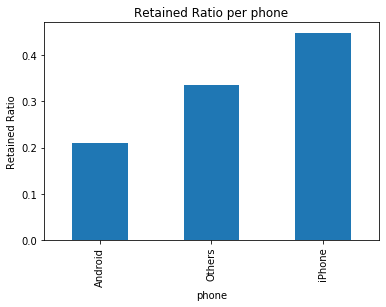

In [20]:
plot_retained_ratio(users_df, 'phone')

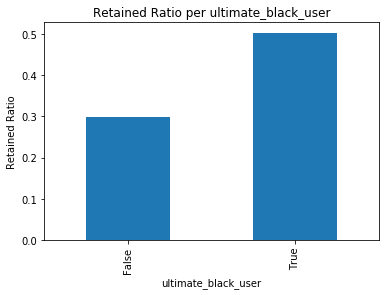

In [21]:
plot_retained_ratio(users_df, 'ultimate_black_user')

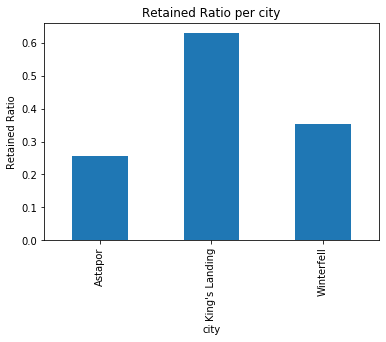

In [22]:
plot_retained_ratio(users_df, 'city')

From the above Plots, we can make below conclusions
1. Many User's of city King's Landing has Retained than other users of other city
2. Ultimate Black User has retained more than Non-ultimate black users
3. IPhone user has retained more than Other and Android Users

After creating models by substituting missing values of average rating by 0, 2.5 and 5.</br>
It was found that model with <b>NaN avg_rating_of_driver</b> and <b>0 avg_rating_by_driver</b> performed better than others.

In [23]:
users_df['avg_rating_by_driver'] = users_df['avg_rating_by_driver'].fillna(0)
# users_df['avg_rating_of_driver'] = users_df['avg_rating_of_driver'].fillna(0)

In [24]:
features = ['city', 'ultimate_black_user', 'phone', 'trips_in_first_30_days', 'avg_rating_of_driver', 'surge_pct', 'weekday_pct', 'avg_dist', 'avg_rating_by_driver']
categories = ['city', 'ultimate_black_user', 'phone']
target = 'retained'

In [25]:
dataset = preprocess(users_df, categories=categories, features=features, target=target)
dataset.head()

,retained,city,ultimate_black_user,phone,trips_in_first_30_days,avg_rating_of_driver,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
0,1,King's Landing,True,iPhone,4,4.7,15.4,46.2,3.67,5.0
1,0,Astapor,False,Android,0,5.0,0.0,50.0,8.26,5.0
2,0,Astapor,False,iPhone,3,4.3,0.0,100.0,0.77,5.0
3,1,King's Landing,True,iPhone,9,4.6,20.0,80.0,2.36,4.9
4,0,Winterfell,False,Android,14,4.4,11.8,82.4,3.13,4.9


In [26]:
X_train, X_test = train_test_split(dataset, random_state=41, test_size=0.2)
X_train, X_val = train_test_split(X_train, random_state=41, test_size=0.25)
print("X_train : {}".format(X_train.shape))
print("X_val : {}".format(X_val.shape))
print("X_test : {}".format(X_test.shape))

X_train : (30000, 10)
X_val : (10000, 10)
X_test : (10000, 10)


In [27]:
model, train_score, val_score, test_score = run_lgbm(X_train, X_val, X_test, features=features, target=target)
train_score, val_score, test_score

(0.8973608393624649, 0.8597566656041175, 0.8545813154186312)

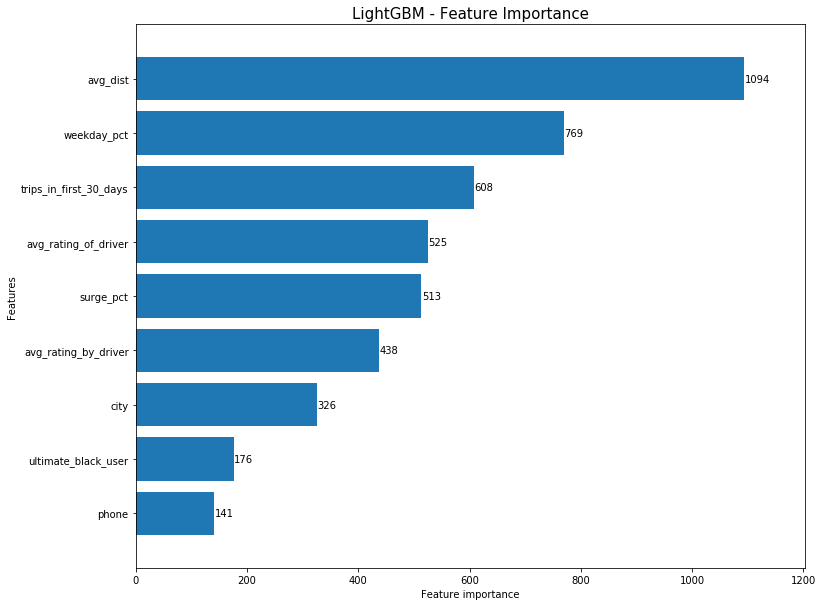

In [28]:
fig, ax = plt.subplots(figsize=(12,10))
lgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
ax.grid(False)
plt.title("LightGBM - Feature Importance", fontsize=15)
plt.show()

In [29]:
feature_importance_by_score(X_train, X_val, X_test, features, target, val_score)

[('city', -0.029140911328760066),
 ('trips_in_first_30_days', -0.017220822851874318),
 ('phone', -0.00964679019364445),
 ('weekday_pct', -0.009400732882572704),
 ('ultimate_black_user', -0.006752247159743097),
 ('surge_pct', -0.006522644692179891),
 ('avg_rating_by_driver', -0.005240676322130766),
 ('avg_rating_of_driver', -0.0031000372423706235),
 ('avg_dist', -0.0010657168607849377)]

From the above predictive model, below are the factors that are best predictors for retention
1. City user signed up in
2. The number of trips this user took in the first 30 days after signing up
3. Primary device for the user
4. The percent of the user’s trips occurring during a weekday
5. User took an Ultimate Black in their first 30 days
6. The percent of trips taken with surge multiplier > 1
7. The rider’s average rating over all of their trips
8. The rider’s average rating of their drivers over all of their trips
9. The average distance in miles per trip taken in the first 30 days after signup